### import

In [1]:
import io

import cv2
import numpy as np
import torch
import uvicorn
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import StreamingResponse
from fastapi.responses import FileResponse
from PIL import Image
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import matplotlib.pyplot as plt
from pathlib import Path


### fastapiアプリの作成とパイプライン

In [2]:
app = FastAPI()
# DeepLabV3 + ResNet50（COCOデータセットで学習済み）を読み込み 推論モードに設定
model = deeplabv3_resnet50(pretrained=True).eval()
# weights = DeepLabV3_ResNet50_Weights.DEFAULT  # or COCO_WITH_VOC_LABELS_V1 など
# model = deeplabv3_resnet50(weights=weights)
# 画像前処理パイプライン
transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

c:\Users\kida0\dev\server\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kida0\dev\server\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 逐次実行用

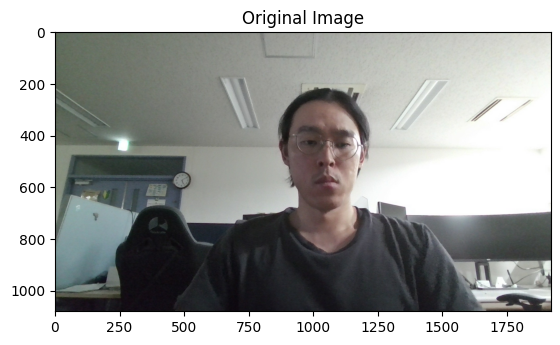

In [3]:
# 画像ファイルの読み込み
img_path = "test.jpg"  
img = Image.open(img_path).convert("RGB")
plt.imshow(img,cmap="jet")
plt.title("Original Image")
plt.show()

In [4]:
# 3. 前処理を適用
print('処理前',img.size)
input_tensor = transform(img)
print('transform後',input_tensor.shape)
input_tensor = input_tensor.unsqueeze(0)  # (1, C, H, W)
print('unsqueeze後',input_tensor.shape)
print(type(input_tensor))
# 4. 推論
# 勾配計算をオフにする,既に推論モードになっている
with torch.no_grad():
    output = model(input_tensor)
    print(output.keys())
    output = output['out'][0]  # (num_classes, H, W)
    preds = output.argmax(0).byte().cpu().numpy()  # 各ピクセルのクラスID
    print(output.shape)
    print(preds.shape)

処理前 (1920, 1080)
transform後 torch.Size([3, 480, 640])
unsqueeze後 torch.Size([1, 3, 480, 640])
<class 'torch.Tensor'>
odict_keys(['out', 'aux'])
torch.Size([21, 480, 640])
(480, 640)


(480, 640)


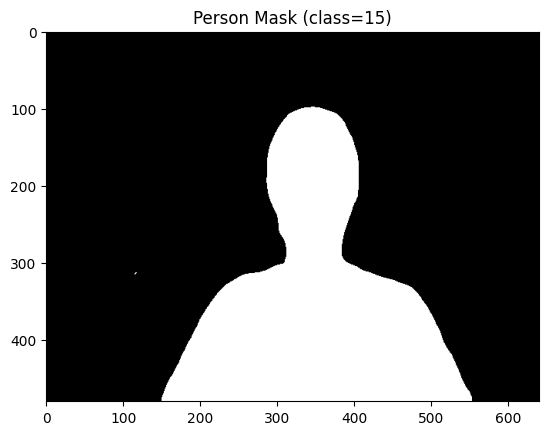

In [5]:
# 5. マスク生成（クラス15=person）
mask = (preds == 15).astype(np.uint8) * 255
print(mask.shape)
plt.imshow(mask, cmap="gray")
plt.title("Person Mask (class=15)")
plt.show()

(1080, 1920, 3)
1080 1920


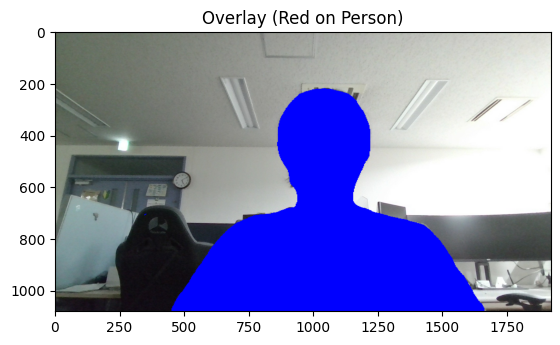

In [6]:
# 6. 元画像にオーバーレイ
np_img = np.array(img)  # 元画像サイズのまま
print(np_img.shape)
h0, w0 = np_img.shape[:2]
print(h0,w0)
# mask を元画像サイズに拡大/縮小,最近傍補間（INTER_NEAREST）を使うことでクラス境界がぼけません
mask_up = cv2.resize(mask, (w0, h0), interpolation=cv2.INTER_NEAREST)

overlay = np_img.copy()
overlay[mask_up == 255] = [0, 0, 255]
plt.imshow(overlay)
plt.title("Overlay (Red on Person)")
plt.show()


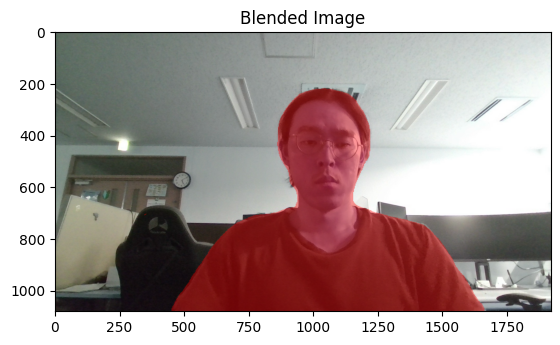

In [7]:
# 7. ブレンド合成
blended = cv2.addWeighted(np_img, 0.6, overlay, 0.4, 0)
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.title("Blended Image")
plt.show()

In [8]:
# 8. JPEGエンコードして保存（StreamingResponseの代わりに保存）
_, jpeg = cv2.imencode(".jpg", blended)
with open("result.jpg", "wb") as f:
    f.write(jpeg.tobytes())

print("処理完了: result.jpg に結果画像を保存しました。")

処理完了: result.jpg に結果画像を保存しました。


### エンドポイント作成

In [9]:
# フォームデータとして画像ファイル(UploadFile)を受け取る
@app.post("/api/detect")
def detect(file: UploadFile = File(...)):
    img = Image.open(file.file).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)['out'][0]
        preds = output.argmax(0).byte().cpu().numpy()

    mask = (preds == 15).astype(np.uint8) * 255
    np_img = np.array(img)
    overlay = np_img.copy()
    overlay[mask == 255] = [0, 0, 255]
    blended = cv2.addWeighted(np_img, 0.6, overlay, 0.4, 0)

    _, jpeg = cv2.imencode(".jpg", blended)
    return StreamingResponse(io.BytesIO(jpeg.tobytes()), media_type="image/jpeg")

@app.get("/api/test")
def get_test_img():
    file_path = Path("test.jpg")
    return FileResponse(
        path=file_path,
        media_type="image/jpeg",
        filename="test.jpg",
    )

### 起動

In [ ]:
# if __name__ == "__main__":
# uvicorn.run(app, host="0.0.0.0", port=8000)
# !uvicorn server:app --host 0.0.0.0 --port 8080